In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os


#importo libreria panda per leggere ed elaborare csv
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

from sklearn.tree import DecisionTreeClassifier

In [2]:
train_data=pd.read_csv('/Users/ragno/Documents/Progetti/Mldm/ProgettoMLDM/Dataset/train_data.csv')
test_data=pd.read_csv('/Users/ragno/Documents/Progetti/Mldm/ProgettoMLDM/Dataset/test_data.csv')
y_train=pd.read_csv('/Users/ragno/Documents/Progetti/Mldm/ProgettoMLDM/Dataset/train_y.csv')
y_test=pd.read_csv('/Users/ragno/Documents/Progetti/Mldm/ProgettoMLDM/Dataset/test_y.csv')


In [3]:
column = ['criterion', 'max_depth', 'ccp_alpha', 'min_samples_leaf', 'min_samples_split', 'accuracy']
column_bar = ['try', 'Parameter_changed', 'Accuracy']

def plot_depthsVSaccuracy(depths, ccp_alpha, title):
  accs = pd.DataFrame(columns=column)
  for d in depths:
    tree_clf = DecisionTreeClassifier(criterion='log_loss',max_depth=d, min_samples_leaf=4, ccp_alpha=ccp_alpha,min_samples_split=8 )
    tree_clf.fit(train_data, y_train)
    testset_score = tree_clf.score(test_data, y_test)
    row = pd.DataFrame(data=[['log_loss', d, ccp_alpha, 4, 8 ,testset_score]], columns=column)
    accs = pd.concat([accs, row])

  # plot
  fig, ax = plt.subplots()
  ax.plot(accs.max_depth, accs.accuracy)

  ax.set(xlabel='Max depth', ylabel='Accuracy',
        title=title)
  ax.grid()
  plt.show()

### Create a single row equivalent to a single try for decision tree
def create_bar_row(criterion, depth, leaf, ccp, split, attempt, parameter):
  tree_clf = DecisionTreeClassifier(criterion=criterion,max_depth=depth, min_samples_leaf=leaf, ccp_alpha=ccp,min_samples_split=split )
  tree_clf.fit(train_data, y_train)
  testset_score = tree_clf.score(test_data, y_test)
  row = pd.DataFrame(data=[[attempt, parameter, testset_score]], columns=column_bar)
  return row

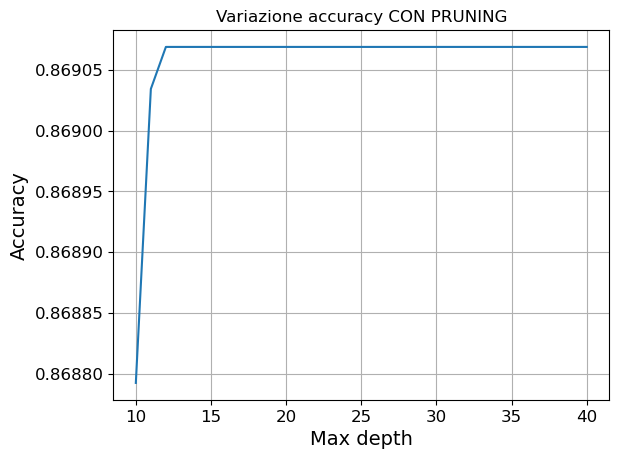

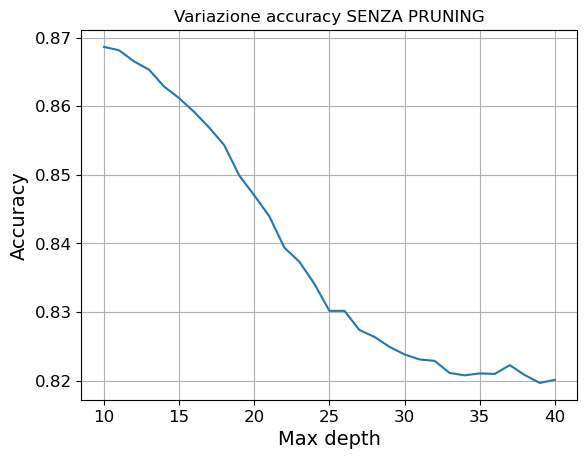

In [4]:
depths = np.linspace(10, 40, 31, dtype=int)

plot_depthsVSaccuracy(depths, 0.0001, 'Variazione accuracy CON PRUNING') # with pruning
plot_depthsVSaccuracy(depths, 0.0, 'Variazione accuracy SENZA PRUNING') # without pruning

  try  Parameter_changed  Accuracy
0   5              start  0.831304
0   5          max_depth  0.839916
0   5   min_samples_leaf  0.858832
0  40  min_samples_split  0.858729
0   5          ccp_alpha  0.868965


<AxesSubplot:title={'center':'Score sul testset durante il tuning dei parametri'}, xlabel='Accuracy', ylabel='Parameter_changed'>

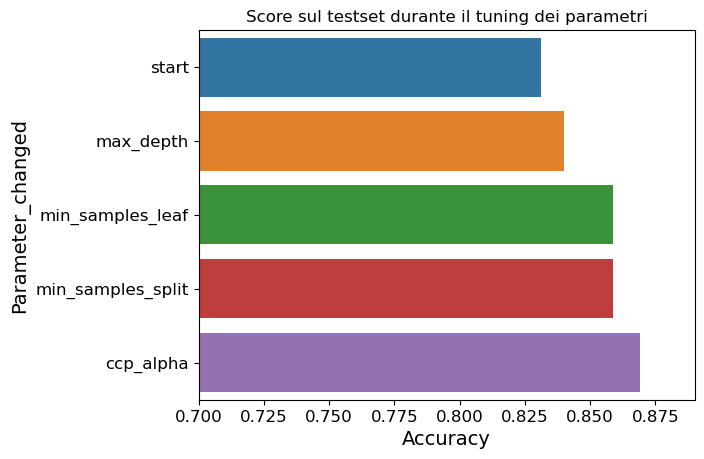

In [5]:
import seaborn as sns
df = pd.DataFrame(columns=column_bar)
df = pd.concat([df, create_bar_row('entropy', 50, 1, 0.0, 20, 5, 'start')]) # try 1
df = pd.concat([df, create_bar_row('entropy', 25, 1, 0.0, 20, 5, 'max_depth')]) # try 2
df = pd.concat([df, create_bar_row('entropy', 25, 10, 0.0, 40, 5, 'min_samples_leaf')]) # try 3
df = pd.concat([df, create_bar_row('entropy', 25, 10, 0.0, 40, 5, 'min_samples_split')]) # try 4
df = pd.concat([df, create_bar_row('entropy', 25, 10, 0.0001, 40, 5, 'ccp_alpha')]) # try 5
print(df)

fig, axs = plt.subplots()
axs.set_xlim([0.70,0.89])
axs.set_title("Score sul testset durante il tuning dei parametri")

sns.barplot(data=df, x='Accuracy',y="Parameter_changed",ax=axs, orient="h")

In [160]:


#GRID SEARCH
tree_clf = DecisionTreeClassifier(max_features=None,max_depth=None, random_state=10, min_samples_leaf=50,min_samples_split=50)

parameter_grid = {
    "max_depth": [10, 20, 30, None],
    "criterion": ['gini', 'entropy', 'log_loss'],
    'random_state': [30, 50, None],
    'min_samples_leaf':[20, 50, 100, 200],
    'ccp_alpha': [.0001],
    'min_samples_split': [6, 8 ]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=5)
cross_validation.get_n_splits(train_data, y_train)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=3,
    scoring=SCORING,
    return_train_score=True,
    refit="balanced_accuracy",
)

grid_search.fit(train_data,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.787, test=0.782) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.870, test=0.866) balanced_accuracy: (train=0.744, test=0.737) f1: (train=0.786, test=0.778) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.739, test=0.741) f1: (train=0.782, test=0.784) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.868) balanced_accuracy: (train=0.74

[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.744, test=0.742) f1: (train=0.784, test=0.783) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.742, test=0.742) f1: (train=0.783, test=0.783) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.745, test=0.742) f1: (train=0.786, test=0.782) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=50; accuracy: (train=0.869, test=0.865) balanced_accuracy: (train=0.742, test=0.735) f1: (train=0.784, test=0.777) total time=   0.2s


[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.864) balanced_accuracy: (train=0.743, test=0.736) f1: (train=0.784, test=0.777) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.869) balanced_accuracy: (train=0.736, test=0.739) f1: (train=0.779, test=0.782) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.737, test=0.736) f1: (train=0.779, test=0.778) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.736, test=0.736) f1: (train=0.778, test=0.779) total time=   0

[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.866, test=0.864) balanced_accuracy: (train=0.742, test=0.739) f1: (train=0.782, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.775) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.866, test=0.868) balanced_accuracy: (train=0.734, test=0.737) f1: (train=0.776, test=0.780) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total t

[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=None; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.747, test=0.745) f1: (train=0.788, test=0.785) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=None; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.747, test=0.747) f1: (train=0.788, test=0.788) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.748, test=0.743) f1: (train=0.788, test=0.783) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.745, test=0.738) f1: (train=0.787, test=0.780) total time=   0

[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=50, min_samples_split=8, random_state=30; accuracy: (train=0.869, test=0.865) balanced_accuracy: (train=0.743, test=0.736) f1: (train=0.785, test=0.777) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=50, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.738, test=0.740) f1: (train=0.780, test=0.783) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=50, min_samples_split=8, random_state=30; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.745, test=0.743) f1: (train=0.786, test=0.783) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=50, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.743, test=0.743) f1: (train=0.784, test=0.784) total time=   0.3s


[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.736, test=0.736) f1: (train=0.778, test=0.779) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.867, test=0.866) balanced_accuracy: (train=0.743, test=0.740) f1: (train=0.783, test=0.780) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.864) balanced_accuracy: (train=0.743, test=0.736) f1: (train=0.784, test=0.777) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.867, test=0.869) balanced_accuracy: (train=0.736, test=0.739) f1: (train=0.779, test=0.782) total time=   0

[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=50; accuracy: (train=0.866, test=0.868) balanced_accuracy: (train=0.734, test=0.737) f1: (train=0.776, test=0.780) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=50; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=50; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.778) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.864) balanced_accuracy: (train=0.742, test=0.739) f1: (train=0.782, test=0.778) total time=  

[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.748, test=0.743) f1: (train=0.788, test=0.783) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.745, test=0.738) f1: (train=0.787, test=0.780) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.782, test=0.785) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.747, test=0.745) f1: (train=0.788, test=0.785) total time=

[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=None; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.745, test=0.743) f1: (train=0.786, test=0.783) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.743, test=0.743) f1: (train=0.784, test=0.784) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.867, test=0.866) balanced_accuracy: (train=0.743, test=0.740) f1: (train=0.783, test=0.780) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.864) balanced_accuracy: (train=0.743, test=0.736) f1: (train=0.784, test=0.777) total time=  

[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=200, min_samples_split=6, random_state=30; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.775) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=200, min_samples_split=6, random_state=30; accuracy: (train=0.866, test=0.868) balanced_accuracy: (train=0.734, test=0.737) f1: (train=0.776, test=0.780) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=200, min_samples_split=6, random_state=30; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=30, min_samples_leaf=200, min_samples_split=6, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.778) total time=   0

[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.747, test=0.747) f1: (train=0.788, test=0.788) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.748, test=0.743) f1: (train=0.788, test=0.783) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.870, test=0.867) balanced_accuracy: (train=0.745, test=0.738) f1: (train=0.787, test=0.780) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.782, test=0.785) total time=

[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.738, test=0.740) f1: (train=0.780, test=0.783) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=50; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.745, test=0.743) f1: (train=0.786, test=0.783) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.743, test=0.743) f1: (train=0.784, test=0.784) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.747, test=0.743) f1: (train=0.786, test=0.783) total tim

[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.867, test=0.866) balanced_accuracy: (train=0.743, test=0.740) f1: (train=0.783, test=0.780) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.868, test=0.864) balanced_accuracy: (train=0.743, test=0.736) f1: (train=0.784, test=0.777) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.867, test=0.869) balanced_accuracy: (train=0.736, test=0.739) f1: (train=0.779, test=0.782) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.737, test=0.736) f1: (train=0.779, test=0.778)

[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=None; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.778) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.864) balanced_accuracy: (train=0.742, test=0.739) f1: (train=0.782, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.775) tot

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.870, test=0.866) balanced_accuracy: (train=0.748, test=0.742) f1: (train=0.788, test=0.782) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.869, test=0.871) balanced_accuracy: (train=0.744, test=0.745) f1: (train=0.785, test=0.787) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.749, test=0.746) f1: (train=0.789, test=0.786) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.870, test=0.869) balanced_accuracy: (train=0.744, test=0.743) f1: (train=0.787, test=0.785) total t

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=50, min_samples_split=8, random_state=30; accuracy: (train=0.869, test=0.868) balanced_accuracy: (train=0.745, test=0.743) f1: (train=0.786, test=0.784) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.742) f1: (train=0.788, test=0.782) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.869, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.786, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.744, test=0.746) f1: (train=0.785, test=0.787) total t

[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, test=0.784) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781) t

[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.867, test=0.865) balanced_accuracy: (train=0.741, test=0.738) f1: (train=0.781, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=10, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.

[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.871, test=0.869) balanced_accuracy: (train=0.751, test=0.748) f1: (train=0.791, test=0.788) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.871, test=0.870) balanced_accuracy: (train=0.750, test=0.747) f1: (train=0.791, test=0.787) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) tot

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, test=0.784) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) tot

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=200, min_samples_split=6, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.739, test=0.739) f1: (train=0.780, test=0.781) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.865) balanced_accuracy: (train=0.741, test=0.738) f1: (train=0.781, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) tot

[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.746, test=0.746) f1: (train=0.788, test=0.788) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.871, test=0.869) balanced_accuracy: (train=0.751, test=0.748) f1: (train=0.791, test=0.788) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.871, test=0.870) balanced_accuracy: (train=0.750, test=0.747) f1: (train=0.791, test=0.787) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=20, min_samples_split=6, random_state=None; accuracy: (train=0.871, test=0.866) balanced_accuracy: (train=0.752, test=0.745) f1: (train=0.792, test=0.784) total

[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.745, test=0.746) f1: (train=0.786, test=0.787) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.748, test=0.745) f1: (train=0.788, test=0.784)

[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, test=0.779)

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=30, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.739, test=0.739) f1: (train=0.780, test=0.781) tot

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=20, min_samples_split=8, random_state=30; accuracy: (train=0.871, test=0.870) balanced_accuracy: (train=0.750, test=0.747) f1: (train=0.791, test=0.787) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.871, test=0.866) balanced_accuracy: (train=0.752, test=0.745) f1: (train=0.792, test=0.784) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.871, test=0.867) balanced_accuracy: (train=0.751, test=0.745) f1: (train=0.791, test=0.784) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.746, test=0.746) f1: (train=0.788, test=0.788)

[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.745, test=0.746) f1: (train=0.786, test=0.787) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.748, test=0.745) f1: (train=0.788, test=0.784) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.746, test=0.744) f1: (train=0.787, test=0.785) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=50, min_samples_split=8, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.78

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=100, min_samples_split=8, random_state=50; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, t

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=None, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.739, test=0.739) f1: (train=0.780,

[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=20, min_samples_split=8, random_state=None; accuracy: (train=0.870, test=0.869) balanced_accuracy: (train=0.744, test=0.743) f1: (train=0.787, test=0.785) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.742) f1: (train=0.788, test=0.782) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.786, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.744, test=0.746) f1: (train=0.785, test=0.787) t

[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, test=0.784) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781)

[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.865) balanced_accuracy: (train=0.741, test=0.738) f1: (train=0.781, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=10, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777)

[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.871, test=0.869) balanced_accuracy: (train=0.751, test=0.748) f1: (train=0.791, test=0.788) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=50; accuracy: (train=0.871, test=0.870) balanced_accuracy: (train=0.750, test=0.747) f1: (train=0.791, test=0.787) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=None; accuracy: (train=0.871, test=0.866) balanced_accuracy: (train=0.752, test=0.745) f1: (train=0.792, test=0.784) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=20, min_samples_split=6, random_state=None; accuracy: (train=0.871, test=0.867) balanced_accuracy: (train=0.751, test=0.745) f1: (train=0.791, test=0.784)

[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.745, test=0.746) f1: (train=0.786, test=0.787) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.748, test=0.745) f1: (train=0.788, test=0.784) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=50, min_samples_split=6, random_state=None; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.746, test=0.744) f1: (train=0.787, test=0.

[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=100, min_samples_split=6, random_state=None; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=100, min_samples_split=8, random_state=30; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, test=0.78

[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.777) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=30; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.739, test=0.739) f1: (train=0.780, test=0.781) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=20, min_samples_leaf=200, min_samples_split=8, random_state=50; accuracy: (train=0.867, test=0.865) balanced_accuracy: (train=0.741, test=0.738) f1: (train=0.781, test=0.778)

[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.871, test=0.866) balanced_accuracy: (train=0.752, test=0.745) f1: (train=0.792, test=0.784) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.871, test=0.867) balanced_accuracy: (train=0.751, test=0.745) f1: (train=0.791, test=0.784) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.746, test=0.746) f1: (train=0.788, test=0.788) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=20, min_samples_split=8, random_state=50; accuracy: (train=0.871, test=0.869) balanced_accuracy: (train=0.751, test=0.748) f1: (train=0.791, test=0.788) tot

[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.748, test=0.745) f1: (train=0.788, test=0.784) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=50; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.746, test=0.744) f1: (train=0.787, test=0.785) total time=   0.3s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=50, min_samples_split=8, random_state=None; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781)

[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, test=0.779) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.739, test=0.742) f1: (train=0.781, test=0.784) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.2s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=100, min_samples_split=8, random_state=None; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, tes

[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=30, min_samples_leaf=200, min_samples_split=8, random_state=None; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.739, test=0.739) f1: (train=0.780, test=0.781) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.871, test=0.866) balanced_accuracy: (train=0.752, test=0.745) f1: (train=0.792, test=0.784) total time=   0.3s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.871, test=0.867) balanced_accuracy: (train=0.751, test=0.745) f1: (train=0.791, test=0.784) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=20, min_samples_split=6, random_state=30; accuracy: (train=0.870, test=0.870) balanced_accuracy: (train=0.746, test=0.746) f1: (train=0.788, test=0

[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.866) balanced_accuracy: (train=0.747, test=0.741) f1: (train=0.787, test=0.781) total time=   0.3s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.870) balanced_accuracy: (train=0.745, test=0.746) f1: (train=0.786, test=0.787) total time=   0.3s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.869, test=0.867) balanced_accuracy: (train=0.748, test=0.745) f1: (train=0.788, test=0.784) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=50, min_samples_split=6, random_state=30; accuracy: (train=0.870, test=0.868) balanced_accuracy: (train=0.746, test=0.744) f1: (train=0.787, test=0.

[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.740, test=0.739) f1: (train=0.782, test=0.780) total time=   0.3s
[CV 5/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.741, test=0.740) f1: (train=0.782, test=0.782) total time=   0.2s
[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.746, test=0.742) f1: (train=0.786, test=0.781) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=100, min_samples_split=6, random_state=50; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.745, test=0.739) f1: (train=0.785, tes

[CV 1/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.865) balanced_accuracy: (train=0.741, test=0.738) f1: (train=0.781, test=0.778) total time=   0.2s
[CV 2/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.741, test=0.735) f1: (train=0.782, test=0.776) total time=   0.2s
[CV 3/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.866, test=0.867) balanced_accuracy: (train=0.737, test=0.739) f1: (train=0.778, test=0.781) total time=   0.2s
[CV 4/5] END ccp_alpha=0.0001, criterion=log_loss, max_depth=None, min_samples_leaf=200, min_samples_split=6, random_state=50; accuracy: (train=0.866, test=0.866) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, tes

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(min_samples_leaf=50,
                                              min_samples_split=50,
                                              random_state=10),
             param_grid={'ccp_alpha': [0.0001],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [20, 50, 100, 200],
                         'min_samples_split': [6, 8],
                         'random_state': [30, 50, None]},
             refit='balanced_accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=3)

In [161]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.7461108177372227
Best parameters: {'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 6, 'random_state': 30}


DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=20,
                       min_samples_leaf=20, min_samples_split=6,
                       random_state=30)

In [162]:
my_model =best_dtc
my_model.fit(train_data, y_train)
my_model.score(test_data,y_test)

0.8691727763176096

RANDOM FOREST

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [14]:
column = ['criterion', 'max_depth', 'max_features', 'n_estimators', 'random_state', 'accuracy']
column_bar = ['try', 'Parameter_changed', 'Accuracy']

### Create a single row equivalent to a single try for decision tree
def create_bar_row(criterion, depth, feature, stimatori,random, attempt, parameter):
  rf = RandomForestClassifier(criterion=criterion,max_depth=depth, max_features=feature,n_estimators=stimatori, random_state=random )
  rf.fit(train_data, np.ravel(y_train))
  testset_score = rf.score(test_data, y_test)
  row = pd.DataFrame(data=[[attempt, parameter, testset_score]], columns=column_bar)
  return row

  try Parameter_changed  Accuracy
0   1             start  0.867029
0   2         max_depth  0.867720
0   3      max_features  0.867236
0   4      n_estimators  0.868204
0   5      n_estimators  0.867513


<AxesSubplot:title={'center':'Score sul testset durante il tuning dei parametri'}, xlabel='Accuracy', ylabel='Parameter_changed'>

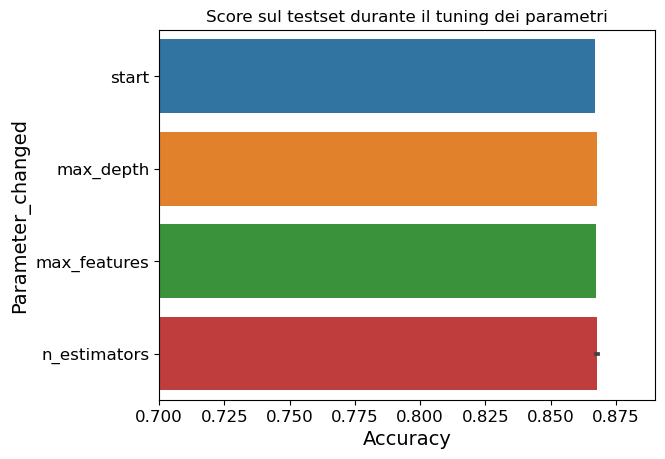

In [18]:
df = pd.DataFrame(columns=column_bar)
df = pd.concat([df, create_bar_row('gini', None, 20, 40, 2,1, 'start')]) # try 1
df = pd.concat([df, create_bar_row('gini', 40, 20, 40, 5,2, 'max_depth')]) # try 1
df = pd.concat([df, create_bar_row('gini', 40, None, 40, 5,3, 'max_features')]) # try 1
df = pd.concat([df, create_bar_row('gini', 40, None, 100, 5,4, 'n_estimators')]) # try 1
df = pd.concat([df, create_bar_row('gini', 40, None, 100, 10,5, 'n_estimators')]) # try 1
print(df)

fig, axs = plt.subplots()
axs.set_xlim([0.70,0.89])
axs.set_title("Score sul testset durante il tuning dei parametri")

sns.barplot(data=df, x='Accuracy',y="Parameter_changed",ax=axs, orient="h")

In [206]:

rf = RandomForestClassifier( n_jobs=-1, n_estimators=50, max_depth=100,max_leaf_nodes=100, random_state=100, max_features=None)

parameter_grid = {
    "n_estimators": [30, 50, 100],
    "max_depth": [10, 40, None],
    "max_features": ["sqrt","log2", None],
    "random_state":[10,30,100],
    "criterion": ['gini', 'entropy', 'log_loss']
}

cross_validation = StratifiedKFold(n_splits=5)
cross_validation.get_n_splits(train_data, np.ravel(y_train))

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=cross_validation,
    verbose=3,
    scoring=SCORING,
    return_train_score=True,
    refit="balanced_accuracy",
)

grid_search.fit(train_data, np.ravel(y_train))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=30; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.737, test=0.731) f1: (train=0.780, test=0.774) total time=   1.3s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=10; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.736, test=0.731) f1: (train=0.779, test=0.774) total time=   1.9s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=100; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.735, test=0.736) f1: (train=0.778, test=0.778) total time=   2.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=100; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.737, test=0.733) f1: (train=0.780, test=0.776) total time=   4.4s
[CV 2/5] END criterion=gini, 

[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=10; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.736, test=0.731) f1: (train=0.779, test=0.773) total time=   1.3s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=100; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.735) f1: (train=0.779, test=0.778) total time=   0.9s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=30; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.735, test=0.735) f1: (train=0.779, test=0.779) total time=   1.9s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=30; accuracy: (train=0.867, test=0.869) balanced_accuracy: (train=0.735, test=0.737) f1: (train=0.778, test=0.781) total time=   3.5s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=30, random_state=10

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(max_depth=100, max_features=None,
                                              max_leaf_nodes=100,
                                              n_estimators=50, n_jobs=-1,
                                              random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 40, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [30, 50, 100],
                         'random_state': [10, 30, 100]},
             refit='balanced_accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=3)

In [208]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc 

Best score: 0.742978958465423
Best parameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'n_estimators': 100, 'random_state': 10}


RandomForestClassifier(max_depth=40, max_features=None, max_leaf_nodes=100,
                       n_jobs=-1, random_state=10)

In [209]:
my_model = best_dtc
my_model.fit(train_data, np.ravel(y_train))
my_model.score(test_data, np.ravel(y_test))

0.8701756812837184

[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=10; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.778) total time=   1.2s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=100; accuracy: (train=0.867, test=0.868) balanced_accuracy: (train=0.735, test=0.737) f1: (train=0.778, test=0.780) total time=   1.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=100; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.734) f1: (train=0.779, test=0.777) total time=   2.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=30; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.736, test=0.732) f1: (train=0.779, test=0.775) total time=   3.9s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=30, random_state=1

[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=10; accuracy: (train=0.868, test=0.869) balanced_accuracy: (train=0.736, test=0.739) f1: (train=0.779, test=0.782) total time=   1.4s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=100; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.734, test=0.735) f1: (train=0.777, test=0.778) total time=   1.2s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=100; accuracy: (train=0.868, test=0.865) balanced_accuracy: (train=0.736, test=0.732) f1: (train=0.779, test=0.774) total time=   2.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=30; accuracy: (train=0.868, test=0.868) balanced_accuracy: (train=0.735, test=0.736) f1: (train=0.778, test=0.779) total time=   4.3s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=30, random_state=3

[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=10; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.734) f1: (train=0.779, test=0.777) total time=   1.3s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=10; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.735) f1: (train=0.779, test=0.777) total time=   1.7s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=100; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.735, test=0.734) f1: (train=0.778, test=0.777) total time=   1.9s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.735, test=0.734) f1: (train=0.779, test=0.777) total time=   4.2s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=30, random_state=30

[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=30, random_state=100; accuracy: (train=0.867, test=0.864) balanced_accuracy: (train=0.737, test=0.731) f1: (train=0.779, test=0.773) total time=   1.5s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50, random_state=30; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.734) f1: (train=0.779, test=0.777) total time=   1.8s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=10; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.736, test=0.734) f1: (train=0.779, test=0.777) total time=   4.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=100; accuracy: (train=0.868, test=0.867) balanced_accuracy: (train=0.735, test=0.734) f1: (train=0.779, test=0.777) total time=   3.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=50, random_state=

[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=30, random_state=10; accuracy: (train=0.867, test=0.866) balanced_accuracy: (train=0.736, test=0.735) f1: (train=0.778, test=0.777) total time=   1.2s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=30, random_state=30; accuracy: (train=0.868, test=0.866) balanced_accuracy: (train=0.735, test=0.731) f1: (train=0.778, test=0.774) total time=   1.3s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=30, random_state=100; accuracy: (train=0.867, test=0.868) balanced_accuracy: (train=0.734, test=0.737) f1: (train=0.777, test=0.780) total time=   1.2s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=50, random_state=10; accuracy: (train=0.867, test=0.867) balanced_accuracy: (train=0.735, test=0.735) f1: (train=0.778, test=0.778) total time=   2.4s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=

EXTRA TREE

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

In [21]:
column = ['criterion','max_features', 'n_estimators', 'random_state', 'accuracy']
column_bar = ['try', 'Parameter_changed', 'Accuracy']

### Create a single row equivalent to a single try for decision tree
def create_bar_row(criterion,feature, stimatori,random, attempt, parameter):
  xt = ExtraTreesClassifier(criterion=criterion,max_features=feature,n_estimators=stimatori, random_state=random, n_jobs=-1 )
  xt.fit(train_data, np.ravel(y_train))
  testset_score = xt.score(test_data, y_test)
  row = pd.DataFrame(data=[[attempt, parameter, testset_score]], columns=column_bar)
  return row

  try Parameter_changed  Accuracy
0   1             start  0.857587
0   1      max_features  0.857587
0   1       n_estimator  0.858556
0   1      random_state  0.858902


<AxesSubplot:title={'center':'Score sul testset durante il tuning dei parametri'}, xlabel='Accuracy', ylabel='Parameter_changed'>

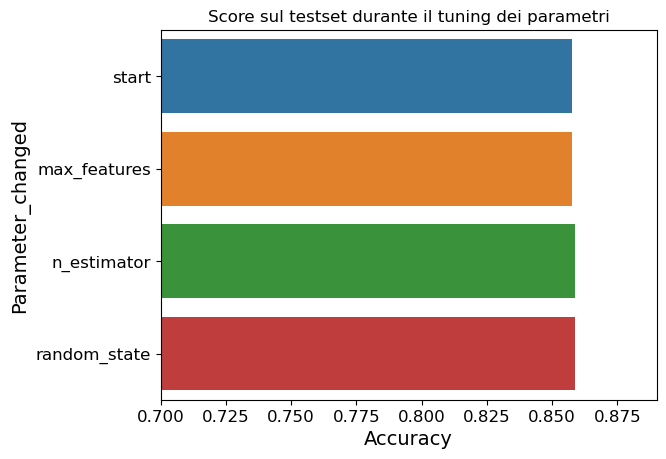

In [27]:
df = pd.DataFrame(columns=column_bar)
df = pd.concat([df, create_bar_row('gini', 'log2', 20, 4, 1, 'start')]) # try 1
df = pd.concat([df, create_bar_row('gini', 'sqrt', 20, 4, 1, 'max_features')]) # try 2
df = pd.concat([df, create_bar_row('gini', 'sqrt', 120, 4, 1, 'n_estimator')]) # try 3
df = pd.concat([df, create_bar_row('gini', 'log2', 120, 30, 1, 'random_state')]) # try 1

print(df)

fig, axs = plt.subplots()
axs.set_xlim([0.70,0.89])
axs.set_title("Score sul testset durante il tuning dei parametri")

sns.barplot(data=df, x='Accuracy',y="Parameter_changed",ax=axs, orient="h")

In [223]:
extra = ExtraTreesClassifier( n_jobs=-1, n_estimators=150, random_state=30)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [100, 200],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_features": ['sqrt', 'log2'],
    "n_jobs":[-1],
   # "bootstrap":[True,False],
    "random_state": [ 50, 100, None],
   # "warm_start": [True, False],
    
}

# Create Stratified folds
# primi tentativi n_splits = 5 per limitare i tempi di esecuzione della gridSearch poi aumentato
cross_validation = StratifiedKFold(n_splits=10)
cross_validation.get_n_splits(train_data, np.ravel(y_train))

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=extra,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=3,
    scoring=SCORING,
    return_train_score=True,
    refit="balanced_accuracy",
)

grid_search.fit(train_data, np.ravel(y_train))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END criterion=gini, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.741) f1: (train=1.000, test=0.775) total time=   2.2s
[CV 2/10] END criterion=gini, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.859) balanced_accuracy: (train=1.000, test=0.744) f1: (train=1.000, test=0.777) total time=   1.2s
[CV 3/10] END criterion=gini, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.742) f1: (train=1.000, test=0.776) total time=   1.1s
[CV 4/10] END criterion=gini, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.856) balanced_accuracy: (train=1.000, test=0.737) f1: (train=1.000, test=0.771) total time=   1.2s
[CV 5/10] END criterion=gini, max_fea

[CV 7/10] END criterion=gini, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.857) balanced_accuracy: (train=1.000, test=0.742) f1: (train=1.000, test=0.775) total time=   2.0s
[CV 8/10] END criterion=gini, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.861) balanced_accuracy: (train=1.000, test=0.747) f1: (train=1.000, test=0.782) total time=   2.1s
[CV 9/10] END criterion=gini, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.744) f1: (train=1.000, test=0.778) total time=   2.1s
[CV 10/10] END criterion=gini, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.863) balanced_accuracy: (train=1.000, test=0.753) f1: (train=1.000, test=0.786) total time=   2.1s
[CV 1/10] END criterion=gini, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=100; acc

[CV 4/10] END criterion=gini, max_features=log2, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.856) balanced_accuracy: (train=1.000, test=0.737) f1: (train=1.000, test=0.771) total time=   1.1s
[CV 5/10] END criterion=gini, max_features=log2, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.744) f1: (train=1.000, test=0.777) total time=   1.1s
[CV 6/10] END criterion=gini, max_features=log2, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.862) balanced_accuracy: (train=1.000, test=0.748) f1: (train=1.000, test=0.783) total time=   1.1s
[CV 7/10] END criterion=gini, max_features=log2, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.856) balanced_accuracy: (train=1.000, test=0.740) f1: (train=1.000, test=0.774) total time=   1.1s
[CV 8/10] END criterion=gini, max_features=log2, n_estimators=100, n_jobs=-1, random_state=100; 

[CV 1/10] END criterion=gini, max_features=log2, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.741) f1: (train=1.000, test=0.775) total time=   2.1s
[CV 2/10] END criterion=gini, max_features=log2, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.741) f1: (train=1.000, test=0.775) total time=   2.0s
[CV 3/10] END criterion=gini, max_features=log2, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.859) balanced_accuracy: (train=1.000, test=0.742) f1: (train=1.000, test=0.776) total time=   2.1s
[CV 4/10] END criterion=gini, max_features=log2, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.855) balanced_accuracy: (train=1.000, test=0.736) f1: (train=1.000, test=0.770) total time=   2.0s
[CV 5/10] END criterion=gini, max_features=log2, n_estimators=200, n_jobs=-1, random_state=N

[CV 7/10] END criterion=entropy, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.742) f1: (train=1.000, test=0.775) total time=   1.1s
[CV 8/10] END criterion=entropy, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.745) f1: (train=1.000, test=0.779) total time=   1.2s
[CV 9/10] END criterion=entropy, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.778) total time=   1.2s
[CV 10/10] END criterion=entropy, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.863) balanced_accuracy: (train=1.000, test=0.752) f1: (train=1.000, test=0.786) total time=   1.1s
[CV 1/10] END criterion=entropy, max_features=sqrt, n_estimators=200, n_jobs=-1

[CV 3/10] END criterion=entropy, max_features=log2, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.857) balanced_accuracy: (train=1.000, test=0.740) f1: (train=1.000, test=0.774) total time=   1.2s
[CV 4/10] END criterion=entropy, max_features=log2, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.855) balanced_accuracy: (train=1.000, test=0.736) f1: (train=1.000, test=0.770) total time=   1.2s
[CV 5/10] END criterion=entropy, max_features=log2, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.776) total time=   1.1s
[CV 6/10] END criterion=entropy, max_features=log2, n_estimators=100, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.862) balanced_accuracy: (train=1.000, test=0.747) f1: (train=1.000, test=0.782) total time=   1.2s
[CV 7/10] END criterion=entropy, max_features=log2, n_estimators=100, n_jobs=-1, random_

[CV 9/10] END criterion=entropy, max_features=log2, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.778) total time=   2.1s
[CV 10/10] END criterion=entropy, max_features=log2, n_estimators=200, n_jobs=-1, random_state=50; accuracy: (train=1.000, test=0.863) balanced_accuracy: (train=1.000, test=0.753) f1: (train=1.000, test=0.786) total time=   2.4s
[CV 1/10] END criterion=entropy, max_features=log2, n_estimators=200, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.744) f1: (train=1.000, test=0.778) total time=   2.1s
[CV 2/10] END criterion=entropy, max_features=log2, n_estimators=200, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.776) total time=   2.1s
[CV 3/10] END criterion=entropy, max_features=log2, n_estimators=200, n_jobs=-1, rand

[CV 5/10] END criterion=log_loss, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.859) balanced_accuracy: (train=1.000, test=0.745) f1: (train=1.000, test=0.778) total time=   1.1s
[CV 6/10] END criterion=log_loss, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.861) balanced_accuracy: (train=1.000, test=0.746) f1: (train=1.000, test=0.781) total time=   1.2s
[CV 7/10] END criterion=log_loss, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.859) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.777) total time=   1.2s
[CV 8/10] END criterion=log_loss, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=100; accuracy: (train=1.000, test=0.861) balanced_accuracy: (train=1.000, test=0.746) f1: (train=1.000, test=0.780) total time=   1.1s
[CV 9/10] END criterion=log_loss, max_features=sqrt, n_estimators=100, n_jobs=-1

[CV 1/10] END criterion=log_loss, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.859) balanced_accuracy: (train=1.000, test=0.741) f1: (train=1.000, test=0.775) total time=   2.0s
[CV 2/10] END criterion=log_loss, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.776) total time=   2.1s
[CV 3/10] END criterion=log_loss, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.741) f1: (train=1.000, test=0.775) total time=   2.0s
[CV 4/10] END criterion=log_loss, max_features=sqrt, n_estimators=200, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.856) balanced_accuracy: (train=1.000, test=0.737) f1: (train=1.000, test=0.771) total time=   2.0s
[CV 5/10] END criterion=log_loss, max_features=sqrt, n_estimators=200, n_job

[CV 7/10] END criterion=log_loss, max_features=log2, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.743) f1: (train=1.000, test=0.776) total time=   1.2s
[CV 8/10] END criterion=log_loss, max_features=log2, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.860) balanced_accuracy: (train=1.000, test=0.746) f1: (train=1.000, test=0.780) total time=   1.1s
[CV 9/10] END criterion=log_loss, max_features=log2, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.858) balanced_accuracy: (train=1.000, test=0.740) f1: (train=1.000, test=0.774) total time=   1.2s
[CV 10/10] END criterion=log_loss, max_features=log2, n_estimators=100, n_jobs=-1, random_state=None; accuracy: (train=1.000, test=0.863) balanced_accuracy: (train=1.000, test=0.752) f1: (train=1.000, test=0.785) total time=   1.1s
[CV 1/10] END criterion=log_loss, max_features=log2, n_estimators=200, n_jo

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(n_estimators=150, n_jobs=-1,
                                            random_state=30),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200], 'n_jobs': [-1],
                         'random_state': [50, 100, None]},
             refit='balanced_accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=3)

In [224]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.7444131043610392
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 50}


ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=50)

In [226]:
my_model = best_dtc
my_model.fit(train_data, np.ravel(y_train))
my_model.score(test_data, np.ravel(y_test))

0.8585558168488034

Risultato accuracy su testSet in base all'algoritmo utilizzato

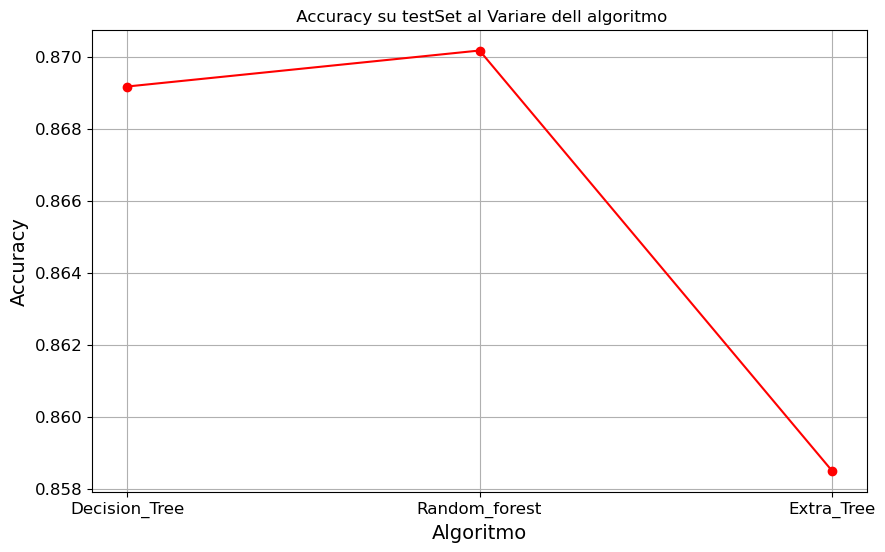

In [19]:
import seaborn as sns
algoritmo=["Decision_Tree","Random_forest","Extra_Tree"]
accuracy=[0.86917,0.87017,0.8585]

plt.figure(figsize=(10, 6))
plt.plot(algoritmo, accuracy, marker='o', linestyle='-', color='r')
plt.title(' Accuracy su testSet al Variare dell algoritmo')
plt.xlabel('Algoritmo')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(algoritmo)
plt.show()